In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
BASE_DIR = "../input/utkface-new/UTKFace"

In [4]:
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR,filename)
    temp = filename.split("_")
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [5]:
df = pd.DataFrame()
df["image"], df["age"], df["gender"] = image_paths, age_labels, gender_labels
df.head(5)

image  age  gender
0  ../input/utkface-new/UTKFace/26_0_2_2017010402...   26       0
1  ../input/utkface-new/UTKFace/22_1_1_2017011223...   22       1
2  ../input/utkface-new/UTKFace/21_1_3_2017010500...   21       1
3  ../input/utkface-new/UTKFace/28_0_0_2017011718...   28       0
4  ../input/utkface-new/UTKFace/17_1_4_2017010322...   17       1

In [6]:
gender_dict = {0:"Male",1:"Female"}

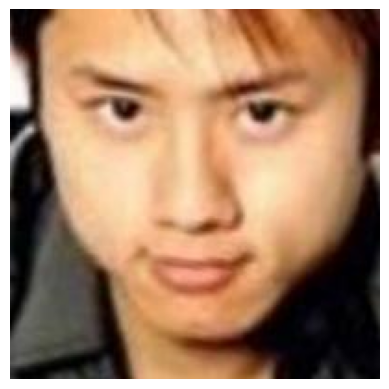

In [7]:
from PIL import Image
img = Image.open(df["image"][0])
plt.axis("off")
plt.imshow(img);

<Axes: xlabel='age', ylabel='Density'>

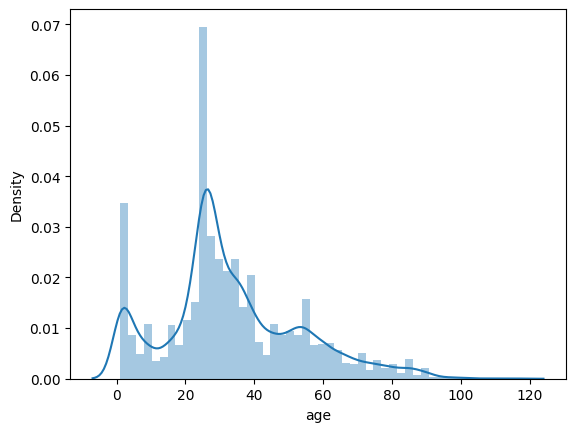

In [8]:
sns.distplot(df["age"])

<Axes: ylabel='count'>

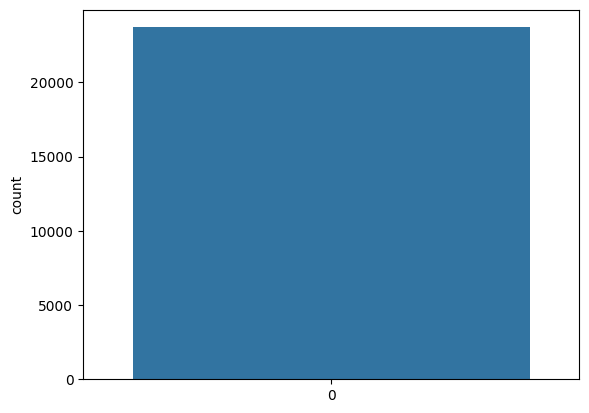

In [9]:
sns.countplot(df["gender"])

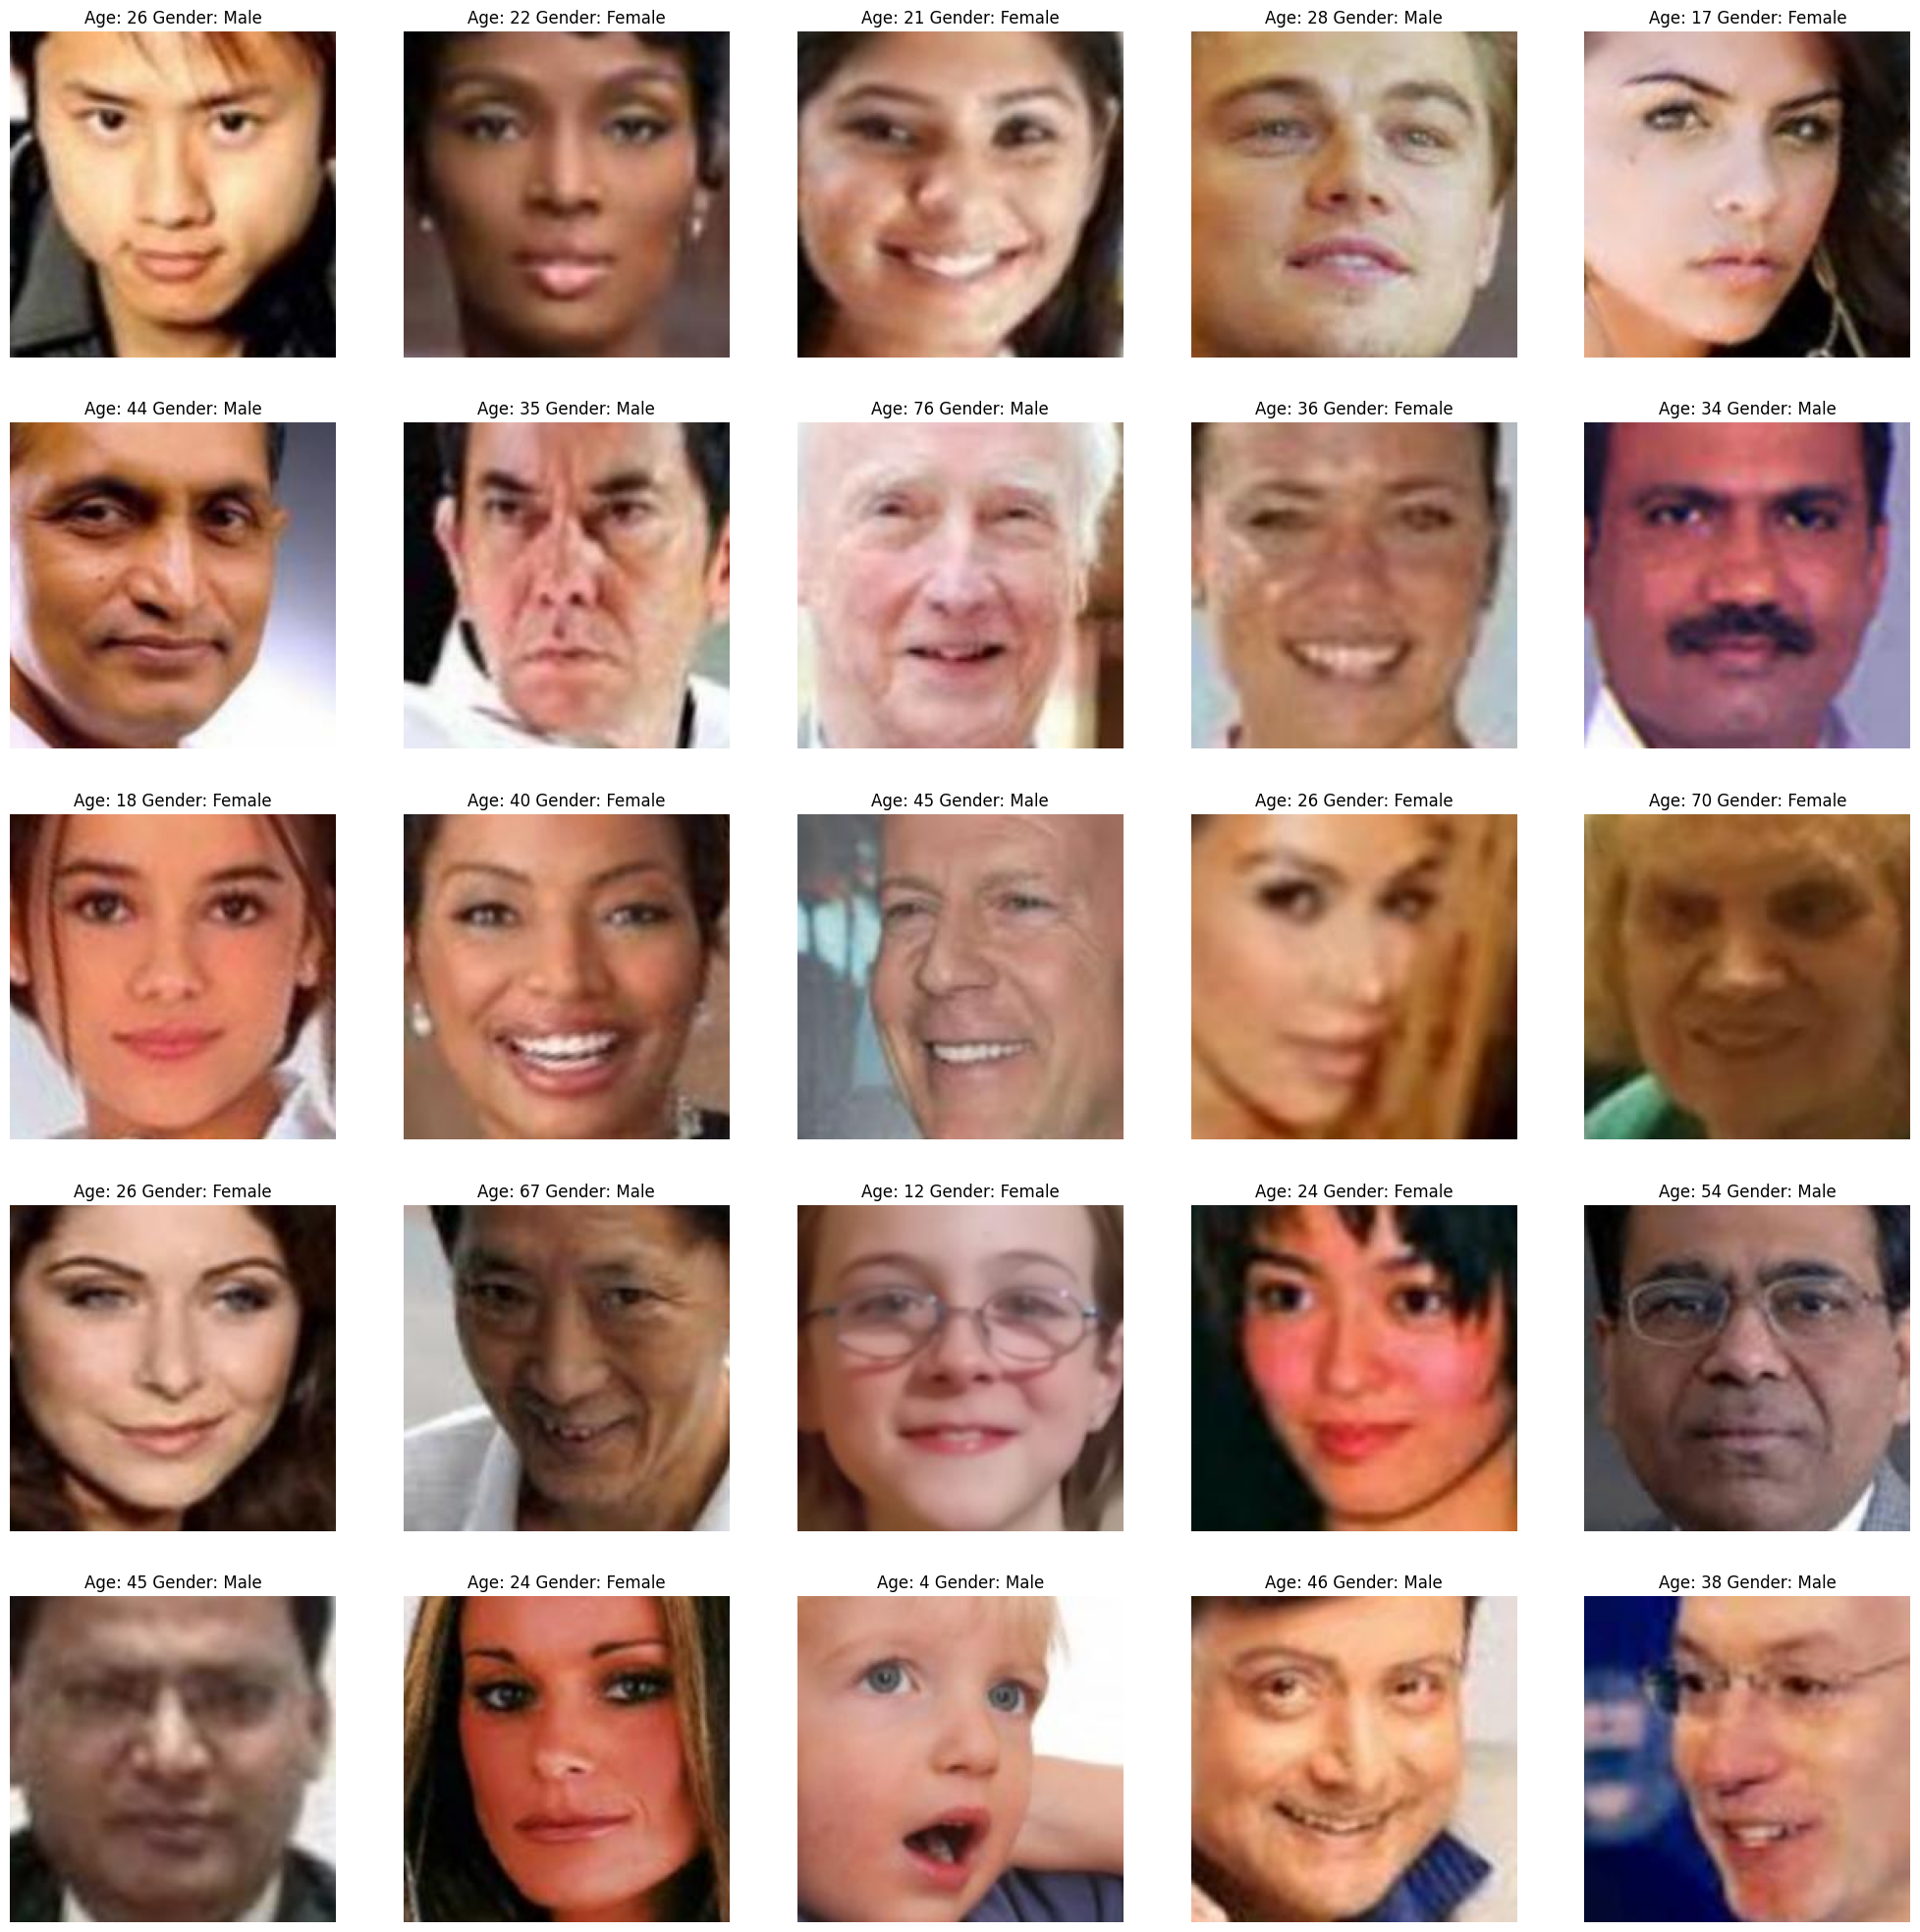

In [10]:
plt.figure(figsize=(25,25))
files = df.iloc[0:25]

for index, file, age, gender in files.itertuples():
    plt.subplot(5,5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis("off")

In [11]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale = True)
        img = img.resize((128,128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [12]:
X = extract_features(df["image"])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [13]:
X.shape

(23708, 128, 128, 1)

In [14]:
X = X/255.0

In [15]:
y_gender = np.array(df["gender"])
y_age = np.array(df["age"])

In [16]:
input_shape = (128,128,1)

In [17]:
inputs = Input(input_shape)
conv_1 = Conv2D(32, kernel_size=(3,3), activation='relu')(inputs)
maxp_1 = MaxPooling2D(pool_size=(2,2))(conv_1)
conv_2 = Conv2D(64, kernel_size=(3,3), activation='relu')(maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2,2))(conv_2)
conv_3 = Conv2D(128, kernel_size=(3,3), activation='relu')(maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2,2))(conv_2)
conv_4 = Conv2D(256, kernel_size=(3,3), activation='relu')(maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2,2))(conv_4)

flatten = Flatten()(maxp_4)

dense_1 = Dense(256, activation='relu')(flatten)
dense_2 = Dense(256, activation='relu')(flatten)

dropout_1 = Dropout(0.3)(dense_1)
dropout_2 = Dropout(0.3)(dense_2)

output_1 = Dense(1, activation='sigmoid', name="gender_out")(dropout_1)
output_2 = Dense(1, activation='relu', name="age_out")(dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=["binary_crossentropy", "mae"], optimizer="adam", metrics=["accuracy"])

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 126, 126, 32)         320       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 61, 61, 64)           18496     ['max_pooling2d[0][0]']   

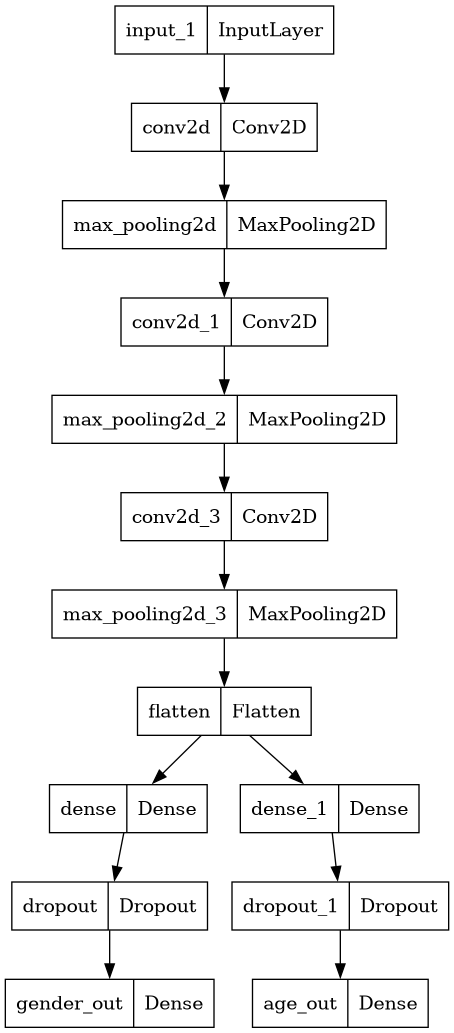

In [19]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [20]:
history = model.fit(x=X, y=[y_gender, y_age], batch_size=32, epochs=30, validation_split=0.2)

Epoch 1/30
593/593 [==============================] - 27s 25ms/step - loss: 13.8589 - gender_out_loss: 0.5573 - age_out_loss: 13.3016 - gender_out_accuracy: 0.7148 - age_out_accuracy: 0.0429 - val_loss: 9.7075 - val_gender_out_loss: 0.3967 - val_age_out_loss: 9.3108 - val_gender_out_accuracy: 0.8195 - val_age_out_accuracy: 0.0226
Epoch 2/30
593/593 [==============================] - 13s 22ms/step - loss: 9.6811 - gender_out_loss: 0.3444 - age_out_loss: 9.3367 - gender_out_accuracy: 0.8462 - age_out_accuracy: 0.0265 - val_loss: 9.3852 - val_gender_out_loss: 0.3168 - val_age_out_loss: 9.0684 - val_gender_out_accuracy: 0.8564 - val_age_out_accuracy: 0.0200
Epoch 3/30
593/593 [==============================] - 13s 22ms/step - loss: 8.6320 - gender_out_loss: 0.2911 - age_out_loss: 8.3409 - gender_out_accuracy: 0.8728 - age_out_accuracy: 0.0218 - val_loss: 7.9609 - val_gender_out_loss: 0.2746 - val_age_out_loss: 7.6862 - val_gender_out_accuracy: 0.8756 - val_age_out_accuracy: 0.0124
Epoch 4/

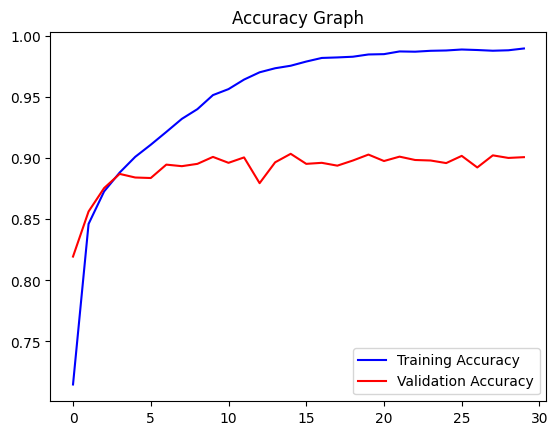

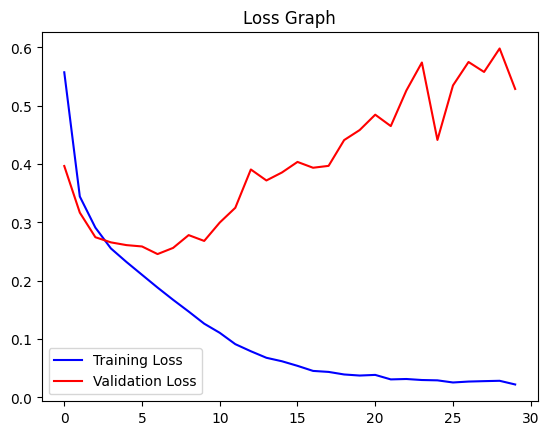

In [21]:
acc = history.history["gender_out_accuracy"]
val_acc = history.history["val_gender_out_accuracy"]

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label="Training Accuracy")
plt.plot(epochs, val_acc, 'r', label="Validation Accuracy")
plt.title("Accuracy Graph")
plt.legend()
plt.figure()

loss = history.history["gender_out_loss"]
val_loss = history.history["val_gender_out_loss"]

plt.plot(epochs, loss, 'b', label="Training Loss")
plt.plot(epochs, val_loss, 'r', label="Validation Loss")
plt.title("Loss Graph")
plt.legend()
plt.show()

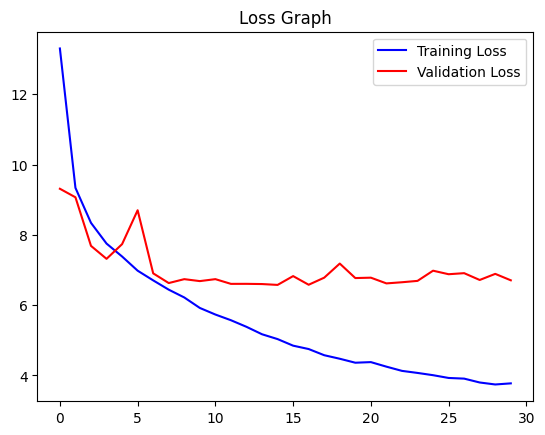

In [22]:
loss = history.history["age_out_loss"]
val_loss = history.history["val_age_out_loss"]

epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label="Training Loss")
plt.plot(epochs, val_loss, 'r', label="Validation Loss")
plt.title("Loss Graph")
plt.legend()
plt.show()

Original Gender: Female, Original Age: 3
1/1 [==============================] - 0s 231ms/step
Predicted Gender: Female, Predicted Age: 3


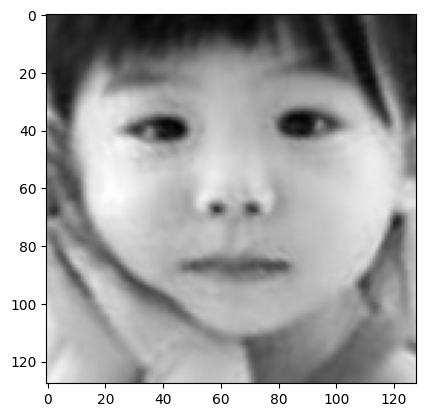

In [23]:
image_index = 100
print(f"Original Gender: {gender_dict[y_gender[image_index]]}, Original Age: {y_age[image_index]}")
pred = model.predict(X[image_index].reshape(1,128,128,1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print(f"Predicted Gender: {pred_gender}, Predicted Age: {pred_age}")
plt.imshow(X[image_index].reshape(128,128), cmap='gray')

Original Gender: Male, Original Age: 28
1/1 [==============================] - 0s 21ms/step
Predicted Gender: Male, Predicted Age: 32


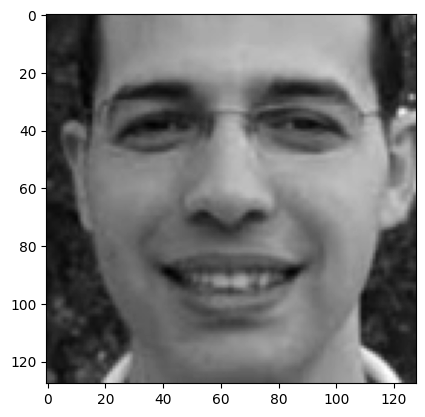

In [24]:
image_index = 3000
print(f"Original Gender: {gender_dict[y_gender[image_index]]}, Original Age: {y_age[image_index]}")
pred = model.predict(X[image_index].reshape(1,128,128,1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print(f"Predicted Gender: {pred_gender}, Predicted Age: {pred_age}")
plt.imshow(X[image_index].reshape(128,128), cmap='gray')

Original Gender: Male, Original Age: 42
1/1 [==============================] - 0s 22ms/step
Predicted Gender: Male, Predicted Age: 42


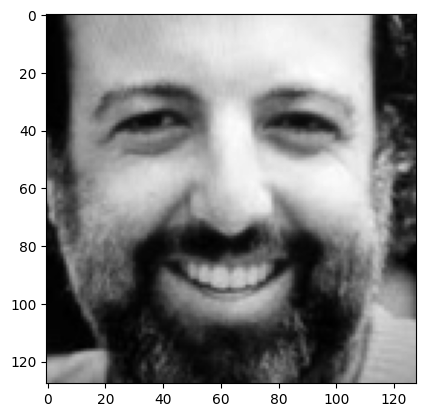

In [25]:
image_index = 10000
print(f"Original Gender: {gender_dict[y_gender[image_index]]}, Original Age: {y_age[image_index]}")
pred = model.predict(X[image_index].reshape(1,128,128,1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print(f"Predicted Gender: {pred_gender}, Predicted Age: {pred_age}")
plt.imshow(X[image_index].reshape(128,128), cmap='gray')

In [26]:
model.save("model.h5")